In [1]:
import sys
sys.path.append("/Users/ueki/.pyenv/versions/3.7.3/lib/python3.7/site-packages")

In [2]:
# requirement
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

In [3]:
# 問題設定

In [4]:
A=np.array([[300,0.5],
                   [0.5,1]])

mu = np.array([[1],[2]])
lam = 0.89

# 解析解

In [5]:
x_1 = np.arange(-1.5, 3, 0.01)
x_2 = np.arange(-1.5, 3, 0.02)

In [6]:
fValue = np.zeros((len(x_1), len(x_2)))

In [7]:
#J(w)を計算してる
for i in range(len(x_1)):
    for j in range(len(x_2)):
        inr = np.vstack([x_1[i], x_2[j]])
        fValue[i, j] = np.dot(np.dot((inr-mu).T, A), (inr- mu)) + lam * (np.abs(x_1[i]) + np.abs(x_2[j]))

In [8]:
# proximal gradient
def st_ops(mu, q):
    x_proj = np.zeros(mu.shape)
    for i in range(len(mu)):
        if mu[i] > q:
            x_proj[i] = mu[i] - q
        else:
            if np.abs(mu[i]) < q:
                x_proj[i] = 0
            else:
                x_proj[i] = mu[i] + q; 
    return x_proj

In [9]:
# cvx
#重みの形
w_lasso = cv.Variable((2,1))
#目的関数(損失関数)
obj_fn = cv.quad_form(w_lasso - mu, A) +  lam * cv.norm(w_lasso, 1)
#目的は、損失関数の最小化
objective = cv.Minimize(obj_fn)
#変数の制約はなし
constraints = []
#問題を定義して解く
prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT) 
w_lasso = w_lasso.value
print(w_lasso)

[[0.99925759]
 [1.55526888]]


# Optimizerを作る
## interface
* init
    * constrctor
* update
    *args ->(param,drad)
    * return->next_param
 
## optimizers
* Adam
* Adagrad
* RMSprop
* AdaDelta
* AdaMax



In [10]:
class Optimizer_handler():
    """
    optimizer に共通のinterfaceを持たせておいて、
    このクラスで実行できるようにする
    """
    def __init__(self,optimizer,itr=500):
        #optimizer
        self.optimizer=optimizer
        #init x_pos
        self.param = np.array([[ 3],[-1]])
        #学習の記録を保存
        self.x_history = []
        self.loss_values = []
        self.g_history = []#gradiant
        self.itr=itr
        
    def learning(self):
        """
        重みの更新を行う
        """
        for _ in range(self.itr):    
            self.x_history.append(self.param.T)
            grad = 2 * np.dot(A, self.param-mu)

            #　xを更新
            self.param  = self.optimizer.update(self.param,grad)
            self.g_history.append(grad.T)
            #損失関数の更新
            fv = np.dot(np.dot((self.param - mu).T, A), (self.param - mu)) + lam * (np.abs(self.param[0]) + np.abs(self.param[1]))
            self.loss_values.append(fv[0])

        print("finish learning")
        print("param->",self.param)
        
    def plot_learning(self):
        """
        学習結果のokit"""
        #　等高線
        X1, X2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
        plt.contour(X1, X2,fValue,80)

        x_history = np.vstack(self.x_history)
        fvalues = np.vstack(self.loss_values)

        plt.xlim(-1.5, 3)
        plt.ylim(-1.5, 3)
        plt.xlabel=("x")
        plt.ylavel=("y")
        plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize=3, linewidth=0.5,label="learning")
        plt.plot(w_lasso[0], w_lasso[1], 'ko',label="ans")
        plt.legend()

## store loss history

In [11]:
Loss_History = {}

# Adam

In [12]:
class Adam:
    """
    Adam
        References
    ----------
        [1] Kingma, Diederik, and Jimmy Ba (2014):
           Adam: A Method for Stochastic Optimization.
           arXiv preprint arXiv:1412.6980.
    """
    def __init__(self,lr=0.001,beta1=0.9,beta2=0.9999,epsilon=1.0e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2=beta2
        self.epsilon=epsilon
        self.m = None
        self.v = None
        self.iter=0
        
        
    def update(self,param,grad):
        """
        params
        ------------
            * param: 更新する値
            * grad：勾配
        ------------
        return
        -----------
            * updated_param
        -----------
        """
        self.iter+=1
        if self.m is None:
            self.m = np.zeros_like(param)
            self.v = np.zeros_like(param)
        
        #momentを更新
        self.m = self.beta1 * self.m+(1-self.beta1)*grad
        self.v = self.beta2 * self.v + (1-self.beta2)* grad*grad
        
        #param更新
        m_hat = self.m/(1-self.beta1**self.iter)
        v_hat = self.v/(1-self.beta2**self.iter)
        update_rate = self.lr * np.ones_like(param)/(np.sqrt(v_hat)+self.epsilon)
        
        next_param = param - m_hat * update_rate
        ret_param = np.array([st_ops(next_param[0], lam  * update_rate[0]),
                        st_ops(next_param[1], lam  * update_rate[1])])
        return ret_param

finish learning
param-> [[1.01384156]
 [1.44627846]]


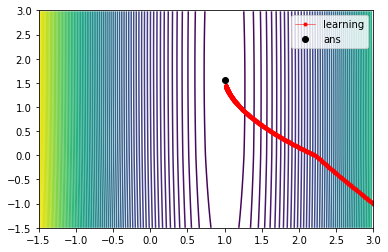

In [13]:
adam = Adam(lr=0.01)
handler = Optimizer_handler(adam)
handler.learning()
handler.plot_learning()
adam_loss_history = handler.loss_values

In [14]:
Loss_History["Adam"] = adam_loss_history

# AdaGrad

In [15]:
class AdaGrad():
    """
    AdaGrad
        References
    ----------
            [1] Duchi, J., Hazan, E., & Singer, Y. (2011):
           Adaptive subgradient methods for online learning and stochastic
           optimization. JMLR, 12:2121-2159.
            [2]
            zeroから始めるdeep-learning
              https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/common/optimizer.py
    """
    def __init__(self,lr=0.1,epsilon=1.0e-8):
        self.lr = lr
        self.epsilon=epsilon
        self.h = None
        
    def update(self,param,grad):
        """
        params
        ------------
            * param: 更新する値
            * grad：勾配
        ------------
        return
        -----------
            * updated_param
        -----------
        """
        if self.h is None:
            self.h = np.zeros_like(param)
        
        
        #h　を更新
        self.h = self.h +np.square(grad)
        
        #paramの更新
        h_tmp = np.sqrt(self.h+self.epsilon)
        ht_inv = h_tmp**-1
        next_param = param -self.lr * grad/(h_tmp)
        ret_param = np.array([st_ops(next_param[0], lam  * self.lr * ht_inv[0]),
                 st_ops(next_param[1], lam  * self.lr* ht_inv[1])])
        return ret_param

finish learning
param-> [[1.01503047]
 [1.40090944]]


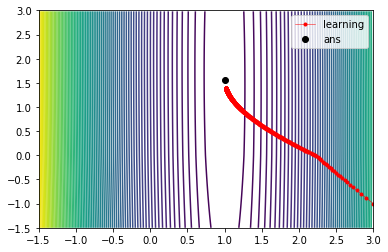

In [16]:
adaGrad = AdaGrad()
handler = Optimizer_handler(adaGrad)
handler.learning()
handler.plot_learning()
adaGrad_loss_history = handler.loss_values

In [17]:
Loss_History["AdaGrad"] = adaGrad_loss_history

# RMSprop

In [18]:
class RMSprop:
    """
    RMSprop
        References
    ----------
             [1]
             Tijmen Tieleman; G. Hinton (2012). Lecture 6.5 - rmsprop, COURSERA: Neural Networks for Machine Learning.
             [2]
             zeroから始めるdeep-learning
             https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/common/optimizer.py
     """
    def __init__(self,lr=0.001,decay_rate=0.99,epsilon=1e-8):
        self.lr = lr
        self.decay_rate=decay_rate
        self.epsilon=epsilon
        self.h = None
        self.iter = 0
        
    def update(self,param,grad):
        """
        params
        ------------
            * param: 更新する値
            * grad：勾配
        ------------
        return
        -----------
            * updated_param
        -----------
        """
        if self.h is None:
            self.h = np.zeros_like(param)
        
        
        #h　を更新
        self.h = self.h * self.decay_rate +( 1 - self.decay_rate)*grad*grad
        
        #paramの更新
        tmp_h = np.sqrt(self.h+self.epsilon)
        ht_inv = tmp_h**-1
        next_param = param -self.lr * grad/tmp_h 
        ret_param = np.array([st_ops(next_param[0], lam  * self.lr * ht_inv[0]),
                 st_ops(next_param[1], lam  * self.lr* ht_inv[1])])
        return ret_param

finish learning
param-> [[0.99926956]
 [1.54977155]]


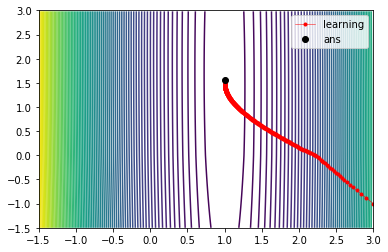

In [19]:
rmsprop = RMSprop(lr=0.01)
handler = Optimizer_handler(rmsprop)
handler.learning()
handler.plot_learning()
RMSprop_loss_history = handler.loss_values

In [20]:
Loss_History["RMSprop"] = RMSprop_loss_history

# AdaDelta

In [21]:
class AdaDelta():
    """
    AdaDelta
        References
    ----------
        [1]Adadelta - an adaptive learning rate method
           https://arxiv.org/abs/1212.5701
        [2]
            zeroから始めるdeep-learning
              https://github.com/oreilly-japan/deep-learning-from-scratch/blob/master/common/optimizer.py
    """
    def __init__(self,decay_rate=0.95,epsilon=1e-8):
        self.epsilon=epsilon
        self.grad_acc=None
        self.param_acc = None
        self.decay_rate = decay_rate
        
    def update(self,param,grad):
        """
        params
        ------------
            * param: 更新する値
            * grad：勾配
        ------------
        return
        -----------
            * updated_param
        -----------
        """
        if self.grad_acc is None:
            self.grad_acc = np.zeros_like(grad)
            self.param_acc = np.zeros_like(param)
            
        
        
        decay_rate = self.decay_rate
        #grad_accumulatorの更新
        self.grad_acc = self.grad_acc*decay_rate + (1-decay_rate)*grad*grad
        
        #prox Rate
        ht = np.sqrt(self.param_acc+self.epsilon)/np.sqrt(self.grad_acc+self.epsilon)
        dx = ht*grad
        # param_accumulatorの更新
        self.param_acc = self.param_acc * decay_rate + (1-decay_rate)*dx*dx
        #paramの更新
        next_param = param- dx
        ret_param = np.array([st_ops(next_param[0], lam * ht[0]),st_ops(next_param[1], lam *ht[1])])
        return ret_param
 

finish learning
param-> [[ 2.72203194]
 [-0.65188187]]


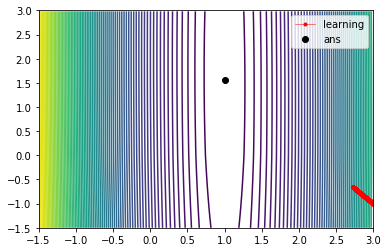

In [22]:
adaDelta = AdaDelta()
handler = Optimizer_handler(adaDelta)
handler.learning()
handler.plot_learning()
adaDelta_loss_history = handler.loss_values

In [23]:
Loss_History["AdaDelta"] = adaDelta_loss_history

# AdaMax

In [24]:
class AdaMax():
    """
    AdaMax
        References
    ----------
        [1]Ganbin Zhou, Ping Luo, Rongyu Cao, Fen Lin, Bo Chen, Qing He. Mechanism-Aware Neural Machine for Dialogue Response Generation. aaai. 2017.
        [2]implementation of keras
        https://github.com/keras-team/keras/blob/master/keras/optimizers.py#L558
    """
    def __init__(self,lr=0.002,beta1 = 0.9,beta2 = 0.999,epsilon=1e-8):
        self.epsilon=epsilon
        self.grad_first=None
        self.grad_second = None
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        
    def update(self,param,grad):
        """
        params
        ------------
            * param: 更新する値
            * grad：勾配
        ------------
        return
        -----------
            * updated_param
        -----------
        """
        if self.grad_first is None:
            self.grad_first = np.zeros_like(grad)
            self.grad_second = np.zeros_like(grad)
        
        #increment iter
        self.iter += 1
        
        # update first gradient
        self.grad_first = self.beta1*self.grad_first +(1-self.beta1)*grad
        
        #update second gradient
        self.grad_second = np.maximum(self.beta2*self.grad_second,np.abs(grad))
        
        # update
        ht = self.lr *self.grad_first/(1-self.beta1)/self.grad_second
        
        #prox_rate
        prox_rate = ht/grad
        
        next_param = param - ht 
        ret_param = np.array([st_ops(next_param[0], lam *prox_rate[0]),st_ops(next_param[1], lam *prox_rate[1])])
        return ret_param
 

finish learning
param-> [[1.00027766]
 [1.54611779]]


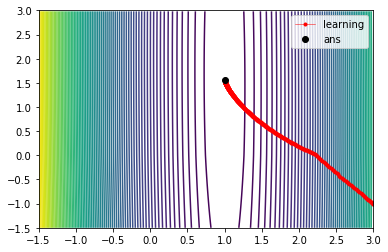

In [25]:
adaMax = AdaMax()
handler = Optimizer_handler(adaMax)
handler.learning()
handler.plot_learning()
adaMax_loss_history = handler.loss_values

In [26]:
Loss_History["AdaMax"] = adaMax_loss_history

## compare performance


## 更新回数ごとのグラフ

In [27]:
def plot_graph(N):
    min_t = np.min(list(Loss_History.values()))
    for key,loss_hist in Loss_History.items():
        plt.semilogy(loss_hist[:N]-min_t,label=key)
    plt.ylabel("loss(J(w^t)-J(W_hat))")
    plt.title("iter = {}".format(N))
    plt.legend()

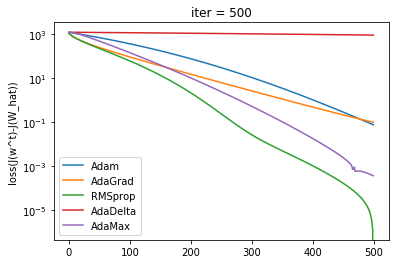

In [28]:
N=500
plot_graph(N)

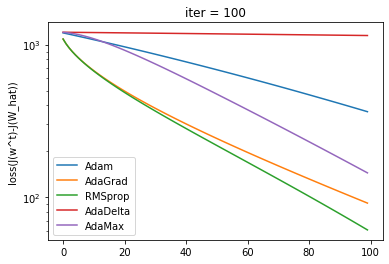

In [29]:
N=100
plot_graph(N)

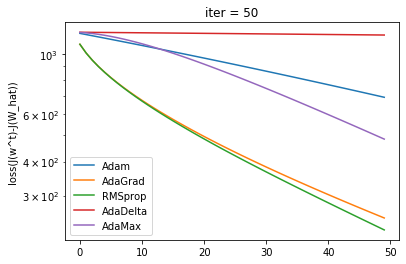

In [30]:
N=50
plot_graph(N)